# Differential Privacy for Location Data: From Intuition to the Square Mechanism

**Author:** Gurjasraj Singh  
**Supervisor:** Professor Vahid  
**Institution:** University of the Fraser Valley

---

## 1. Introduction

Imagine you have a dataset of people's locations on a map. You want to share this data for research, but you also want to **protect each person's privacy**. You don't want anyone to figure out exactly where a specific person is.

This is the core problem **Differential Privacy (DP)** solves.

The idea is simple: instead of sharing exact locations, we introduce **controlled randomness** into the data. That way, if someone looks at the released data, they cannot determine whether any given point represents a person's real location or a perturbed version.

This notebook progresses through four stages:

1. **Intuitive demonstration** using Gaussian noise (a naive approach)
2. **Formal definitions** of $\varepsilon$-differential privacy
3. **Central vs. Local Differential Privacy** and why LDP matters for location data
4. **The Square Mechanism** — a provably $\varepsilon$-differentially private mechanism designed for bounded 2D location domains

Let's begin step by step.

---

## Part I: Intuitive Demonstration — The Gaussian Noise Approach

### 2. The Original Data

We start with a simple setup: a **1×1 square** representing our map (the domain $\mathcal{D} = [0, 1] \times [0, 1]$). We randomly place **100 individuals** (points) inside this square. These are their **true locations** — the data we want to protect.

In [2]:
# Code Block 1: Setup and Parameters
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D

# --- Parameters ---
n = 100         # number of points
p = 0.5         # privacy threshold (0 to 1)
sigma = 0.1     # standard deviation of Gaussian noise

# Generate random points in the unit square
np.random.seed(42)
original = np.random.uniform(0, 1, size=(n, 2))

print(f"Generated {n} true locations in the unit square [0,1] × [0,1]")
print(f"Privacy threshold p = {p}")
print(f"Gaussian noise σ = {sigma}")

Generated 100 true locations in the unit square [0,1] × [0,1]
Privacy threshold p = 0.5
Gaussian noise σ = 0.1


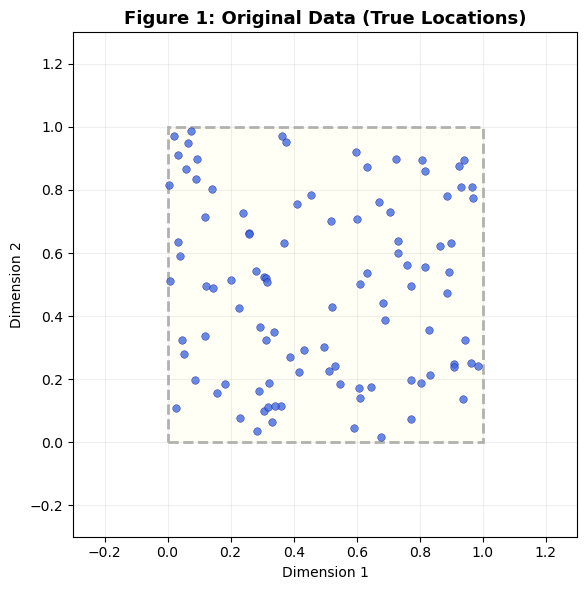

In [3]:
# Figure 1: Original Data (True Locations)
fig, ax = plt.subplots(figsize=(6, 6))
ax.add_patch(patches.Rectangle((0, 0), 1, 1, linewidth=2,
             edgecolor='black', facecolor='lightyellow', alpha=0.3, linestyle='--'))
ax.scatter(original[:, 0], original[:, 1], c='royalblue', s=30, alpha=0.8,
           edgecolors='navy', linewidths=0.3)
ax.set_xlim(-0.3, 1.3)
ax.set_ylim(-0.3, 1.3)
ax.set_aspect('equal')
ax.set_title('Figure 1: Original Data (True Locations)', fontsize=13, fontweight='bold')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

### 3. The Gaussian Noise Mechanism (Naive Approach)

For **each point**, we decide whether to report the **true location** or a **noisy (shifted) version**. We generate a random number $r \sim \text{Uniform}(0, 1)$ for each point:

- If $r < p$: report the **true** location
- If $r \geq p$: add **Gaussian noise** $\mathcal{N}(0, \sigma^2)$ independently to each coordinate

The noise comes from a **Gaussian (normal) distribution** — most shifts are small, but occasionally a point gets moved further away.

**Why does this attempt to protect privacy?** Because an observer looking at the final data cannot immediately tell whether any given point is real or noisy. However, as we will see, this approach has a fundamental flaw for bounded location domains.

In [4]:
# Code Block 2: Apply the Gaussian Noise Mechanism
reported_gauss = original.copy()

# For each point, generate a random number r on [0, 1]
r = np.random.uniform(0, 1, size=n)

# If r >= p, add Gaussian noise
noisy_mask = r >= p
n_noisy = noisy_mask.sum()
n_true = n - n_noisy

noise = np.random.normal(0, sigma, size=(n_noisy, 2))
reported_gauss[noisy_mask] += noise

# Count how many escaped the domain
escaped = np.sum((reported_gauss[:, 0] < 0) | (reported_gauss[:, 0] > 1) |
                 (reported_gauss[:, 1] < 0) | (reported_gauss[:, 1] > 1))

print(f"Table 1: Gaussian Mechanism Summary")
print(f"{'='*45}")
print(f"  Total points:              {n}")
print(f"  Reported TRUE location:    {n_true}  (r < {p})")
print(f"  Reported NOISY location:   {n_noisy}  (r ≥ {p})")
print(f"  Points escaped domain:     {escaped}")
print(f"{'='*45}")

Table 1: Gaussian Mechanism Summary
  Total points:              100
  Reported TRUE location:    42  (r < 0.5)
  Reported NOISY location:   58  (r ≥ 0.5)
  Points escaped domain:     7


### 4. Data After Gaussian Perturbation

Figure 2 shows the **reported locations** after applying Gaussian noise. Notice that some points have drifted **outside the original square**. 

**⚠️ This is a limitation, not a feature.** When perturbed points escape the bounded domain $\mathcal{D}$, it creates two problems:

1. **Privacy leakage:** If an observer sees a point outside the domain, they know with certainty it was perturbed — and can infer that the true location was near the boundary. This violates the privacy guarantee.
2. **Domain distortion:** The released data no longer represents locations within the area we intended to protect, which reduces data utility.

This motivates the need for mechanisms that **guarantee perturbed points remain within the domain** — which is exactly what the Square Mechanism achieves (Part IV).

/var/folders/rp/5bnw0c2d731dfjpybxqc7q200000gn/T/ipykernel_13801/1326499249.py:15: UserWarning: You passed a edgecolor/edgecolors ('darkred') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(reported_gauss[~inside_mask, 0], reported_gauss[~inside_mask, 1],


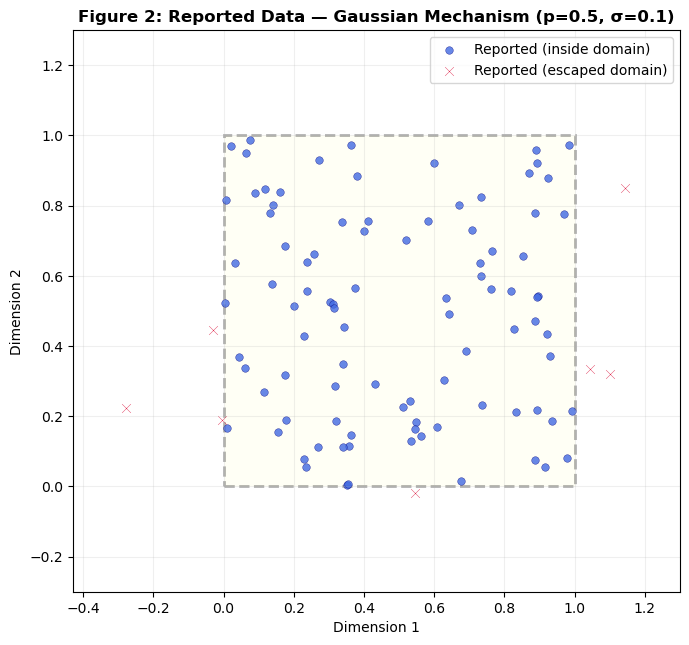


Note: 7 points escaped the domain [0,1]×[0,1].
This reveals that those points were perturbed — a privacy leak.


In [5]:
# Figure 2: Reported Data After Gaussian Noise
# (Extended margins per feedback to show all points, including those near (-0.16, 0.21))

fig, ax = plt.subplots(figsize=(7, 7))
ax.add_patch(patches.Rectangle((0, 0), 1, 1, linewidth=2,
             edgecolor='black', facecolor='lightyellow', alpha=0.3, linestyle='--'))

# Color points: blue if inside domain, red if escaped
inside_mask = ((reported_gauss[:, 0] >= 0) & (reported_gauss[:, 0] <= 1) &
               (reported_gauss[:, 1] >= 0) & (reported_gauss[:, 1] <= 1))

ax.scatter(reported_gauss[inside_mask, 0], reported_gauss[inside_mask, 1],
           c='royalblue', s=30, alpha=0.8, edgecolors='navy', linewidths=0.3,
           label='Reported (inside domain)')
ax.scatter(reported_gauss[~inside_mask, 0], reported_gauss[~inside_mask, 1],
           c='crimson', s=40, alpha=0.9, edgecolors='darkred', linewidths=0.3,
           marker='x', label='Reported (escaped domain)')

# Compute dynamic margins to show ALL points
all_coords = reported_gauss.flatten()
margin = 0.15
x_min = min(-0.3, reported_gauss[:, 0].min() - margin)
x_max = max(1.3, reported_gauss[:, 0].max() + margin)
y_min = min(-0.3, reported_gauss[:, 1].min() - margin)
y_max = max(1.3, reported_gauss[:, 1].max() + margin)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_aspect('equal')
ax.legend(fontsize=10, loc='upper right')
ax.set_title(f'Figure 2: Reported Data — Gaussian Mechanism (p={p}, σ={sigma})',
             fontsize=12, fontweight='bold')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

print(f"\nNote: {(~inside_mask).sum()} points escaped the domain [0,1]×[0,1].")
print(f"This reveals that those points were perturbed — a privacy leak.")

### 5. Visualizing the Perturbation — Original vs. Reported

Figure 3 overlays both datasets to reveal the **geometric effect** of Gaussian noise perturbation.

**Color scheme** :
- **Blue points without lines** = true locations reported as-is (no noise added)
- **Blue points connected by lines to red points** = true locations that were perturbed
- The **line length** shows how far each point was shifted

This two-color scheme makes interpretation straightforward: blue represents truth, and a blue-to-red connection shows the perturbation vector.

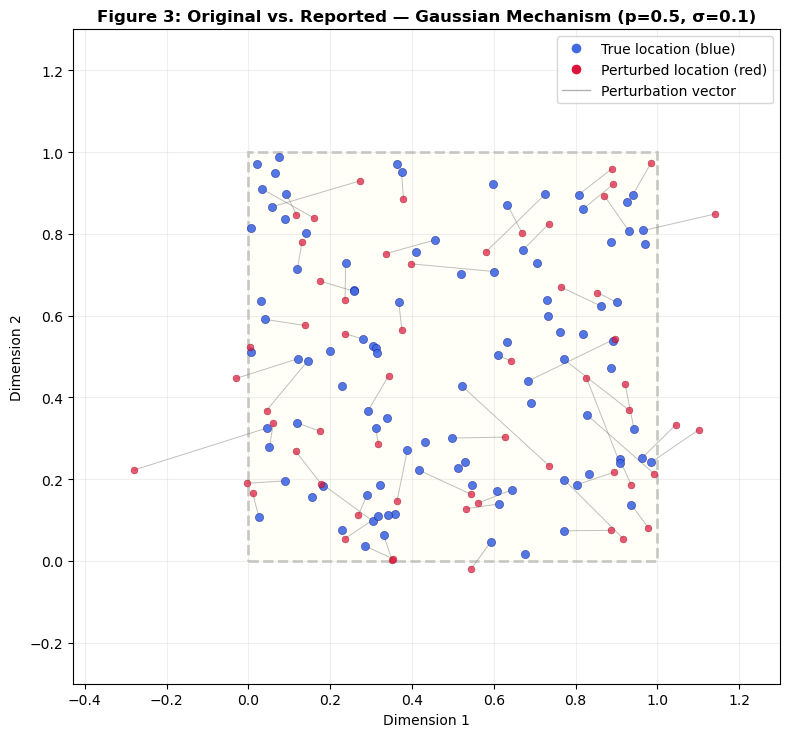

In [6]:
# Figure 3: Overlay — Original vs. Reported (Gaussian Mechanism)
fig, ax = plt.subplots(figsize=(8, 8))
ax.add_patch(patches.Rectangle((0, 0), 1, 1, linewidth=2,
             edgecolor='black', facecolor='lightyellow', alpha=0.2, linestyle='--'))

# Draw lines connecting original to reported (only for perturbed points)
for i in range(n):
    if noisy_mask[i]:
        ax.plot([original[i, 0], reported_gauss[i, 0]],
                [original[i, 1], reported_gauss[i, 1]],
                color='grey', linewidth=0.7, alpha=0.5)

# Plot true locations in blue
ax.scatter(original[:, 0], original[:, 1], c='royalblue', s=35, alpha=0.9,
           edgecolors='navy', linewidths=0.3, zorder=3)

# Plot perturbed locations in red (only the ones that got noise)
ax.scatter(reported_gauss[noisy_mask, 0], reported_gauss[noisy_mask, 1],
           c='crimson', s=25, alpha=0.7, edgecolors='darkred', linewidths=0.3, zorder=4)

# Custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='royalblue',
           markersize=8, label='True location (blue)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='crimson',
           markersize=8, label='Perturbed location (red)'),
    Line2D([0], [0], color='grey', linewidth=1, alpha=0.6,
           label='Perturbation vector')
]
ax.legend(handles=legend_elements, fontsize=10, loc='upper right')

# Dynamic margins to show all points
margin = 0.15
x_min = min(-0.3, reported_gauss[:, 0].min() - margin)
x_max = max(1.3, reported_gauss[:, 0].max() + margin)
y_min = min(-0.3, reported_gauss[:, 1].min() - margin)
y_max = max(1.3, reported_gauss[:, 1].max() + margin)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

ax.set_aspect('equal')
ax.set_title(f'Figure 3: Original vs. Reported — Gaussian Mechanism (p={p}, σ={sigma})',
             fontsize=12, fontweight='bold')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

### 6. Summary of the Gaussian Approach

The Gaussian noise mechanism provides an **intuitive demonstration** of differential privacy. The two parameters are:

- **$p$ (threshold)** — controls *how many* points get noise. Higher $p$ = more true reports = better data utility but weaker privacy.
- **$\sigma$ (noise scale)** — controls *how much* noise is added. Higher $\sigma$ = larger shifts = stronger privacy but more distortion.

**However, this mechanism has fundamental limitations:**

1. **No formal privacy guarantee:** It does not satisfy the mathematical definition of $\varepsilon$-differential privacy (defined in Part II).
2. **Domain escape:** Gaussian noise is unbounded, so perturbed points can land outside the domain $\mathcal{D}$, leaking information about which points were perturbed.
3. **No utility control:** There is no principled way to tune the parameters to achieve a specific privacy-utility tradeoff.

To address these issues, we need to move to formally grounded mechanisms. We begin by defining $\varepsilon$-differential privacy rigorously.

---

## Part II: Formal Definition of $\varepsilon$-Differential Privacy

### 7. The Mathematical Definition

Differential privacy, introduced by Dwork et al. (2006), provides a rigorous mathematical guarantee about how much information a mechanism reveals about any single individual.

**Definition 7.1 ($\varepsilon$-Differential Privacy).** A randomized mechanism $\mathcal{M}: \mathcal{X} \rightarrow \mathcal{Y}$ satisfies $\varepsilon$-differential privacy if, for all pairs of neighboring inputs $x, x' \in \mathcal{X}$ and for all measurable subsets $S \subseteq \mathcal{Y}$:

$$\Pr[\mathcal{M}(x) \in S] \leq e^{\varepsilon} \cdot \Pr[\mathcal{M}(x') \in S]$$

**What does this mean intuitively?**

- Two inputs $x$ and $x'$ are **neighboring** if they differ in exactly one individual's data.
- The definition says: changing one person's data can change the probability of *any* output by at most a multiplicative factor of $e^{\varepsilon}$.
- A smaller $\varepsilon$ means **stronger privacy** (the output distributions are nearly identical regardless of any one person's data).
- A larger $\varepsilon$ means **weaker privacy** but potentially better data utility.

**The privacy parameter $\varepsilon$ (epsilon):**

| $\varepsilon$ | Privacy Level | Interpretation |
|---|---|---|
| 0.1 | Very strong | Outputs barely change when one person's data changes |
| 1.0 | Moderate | Standard choice in many applications |
| 5.0 | Weak | Significant information leakage possible |
| $\infty$ | None | No privacy guarantee |

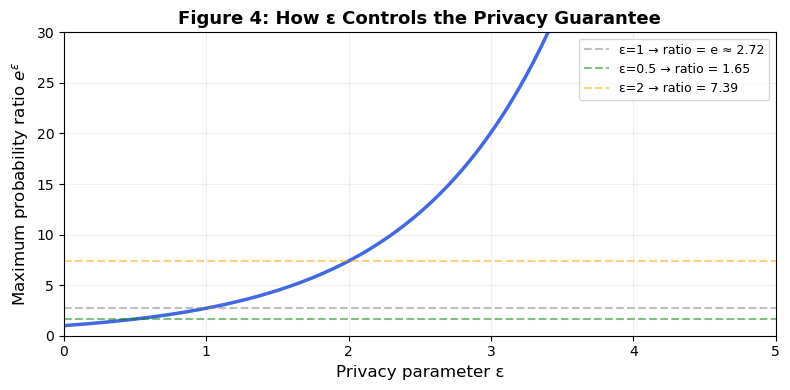

Interpretation: Smaller ε → tighter bound on probability ratio → stronger privacy


In [7]:
# Code Block 3: Visualizing the effect of epsilon
# Demonstrating how epsilon controls the probability ratio bound

fig, ax = plt.subplots(figsize=(8, 4))

epsilons = np.linspace(0.01, 5, 200)
ratios = np.exp(epsilons)

ax.plot(epsilons, ratios, 'royalblue', linewidth=2.5)
ax.axhline(y=np.exp(1), color='grey', linestyle='--', alpha=0.5, label=f'ε=1 → ratio = e ≈ {np.e:.2f}')
ax.axhline(y=np.exp(0.5), color='green', linestyle='--', alpha=0.5, label=f'ε=0.5 → ratio = {np.exp(0.5):.2f}')
ax.axhline(y=np.exp(2), color='orange', linestyle='--', alpha=0.5, label=f'ε=2 → ratio = {np.exp(2):.2f}')

ax.set_xlabel('Privacy parameter ε', fontsize=12)
ax.set_ylabel('Maximum probability ratio $e^{ε}$', fontsize=12)
ax.set_title('Figure 4: How ε Controls the Privacy Guarantee', fontsize=13, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.2)
ax.set_xlim(0, 5)
ax.set_ylim(0, 30)
plt.tight_layout()
plt.show()

print("Interpretation: Smaller ε → tighter bound on probability ratio → stronger privacy")

---

## Part III: Central vs. Local Differential Privacy

### 8. Two Models of Trust

In differential privacy, **who adds the noise** fundamentally changes the trust assumptions and privacy guarantees.

#### 8.1 Central Differential Privacy (CDP)

In the **central model**, a **trusted curator** (e.g., a government agency or company) collects everyone's true data, then adds noise to the aggregate results before releasing them.

$$\text{Users} \xrightarrow{\text{true data}} \boxed{\text{Trusted Curator}} \xrightarrow{\text{noisy output}} \text{Public}$$

- **Trust assumption:** Users must trust the curator with their real data.
- **Advantage:** Since noise is added to aggregates, less noise is needed — better utility.
- **Risk:** If the curator is compromised, all true data is exposed.

#### 8.2 Local Differential Privacy (LDP)

In the **local model**, there is **no trusted curator**. Each individual perturbs their own data *before* sending it to anyone.

$$\text{Each User} \xrightarrow[\text{perturb locally}]{\text{noisy data}} \text{Collector} \xrightarrow{\text{aggregate}} \text{Public}$$

- **Trust assumption:** None — even the data collector only sees noisy data.
- **Advantage:** Maximum privacy — no single point of failure.
- **Cost:** More noise is needed per individual, reducing utility.

### 9. Why LDP for Location Privacy?

Our project concerns **location privacy**: protecting where individuals physically are. The local model (LDP) is the natural choice because:

1. **No trusted server needed:** Each person's device (phone, GPS unit) runs the perturbation mechanism locally before sharing any location data.
2. **Real-world deployment:** Systems like Apple's differential privacy and Google's RAPPOR use LDP.
3. **Regulatory alignment:** LDP satisfies privacy requirements without requiring trust in any third party.

Under LDP, the mechanism $f$ takes a single individual's true location $p$ and outputs a perturbed location $\tilde{p}$, satisfying:

$$\Pr[f(p) = \tilde{p}] \leq e^{\varepsilon} \cdot \Pr[f(p') = \tilde{p}]$$

for all true locations $p, p'$ in the domain $\mathcal{D}$ and all possible outputs $\tilde{p}$.

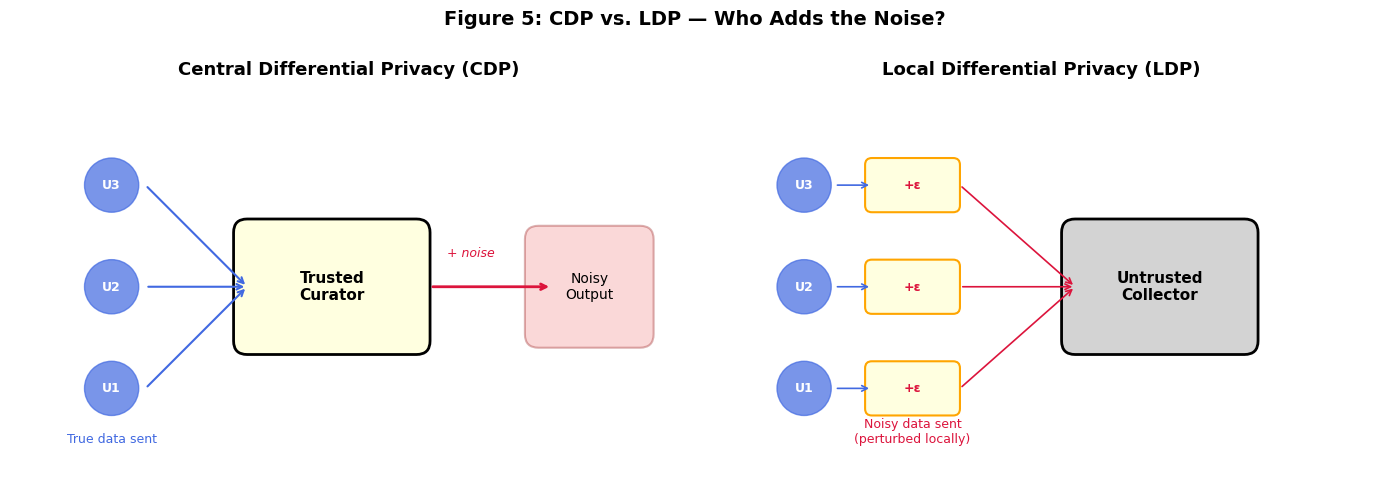

In [8]:
# Code Block 4: Visualizing CDP vs LDP architectures
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# --- CDP Diagram ---
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 6)
ax1.set_aspect('equal')

# Users
for i, y in enumerate([1.5, 3.0, 4.5]):
    ax1.add_patch(plt.Circle((1.5, y), 0.4, color='royalblue', alpha=0.7))
    ax1.text(1.5, y, f'U{i+1}', ha='center', va='center', fontsize=9, color='white', fontweight='bold')
    ax1.annotate('', xy=(3.5, 3.0), xytext=(2.0, y),
                 arrowprops=dict(arrowstyle='->', color='royalblue', lw=1.5))

# Curator
ax1.add_patch(patches.FancyBboxPatch((3.5, 2.2), 2.5, 1.6, boxstyle="round,pad=0.2",
              facecolor='lightyellow', edgecolor='black', linewidth=2))
ax1.text(4.75, 3.0, 'Trusted\nCurator', ha='center', va='center', fontsize=11, fontweight='bold')

# Output
ax1.annotate('', xy=(8.0, 3.0), xytext=(6.2, 3.0),
             arrowprops=dict(arrowstyle='->', color='crimson', lw=2))
ax1.text(6.8, 3.5, '+ noise', ha='center', va='center', fontsize=9, color='crimson', fontstyle='italic')

ax1.add_patch(patches.FancyBboxPatch((7.8, 2.3), 1.5, 1.4, boxstyle="round,pad=0.2",
              facecolor='lightcoral', edgecolor='darkred', linewidth=1.5, alpha=0.3))
ax1.text(8.55, 3.0, 'Noisy\nOutput', ha='center', va='center', fontsize=10)

ax1.set_title('Central Differential Privacy (CDP)', fontsize=13, fontweight='bold')
ax1.text(1.5, 0.7, 'True data sent', ha='center', fontsize=9, color='royalblue')
ax1.axis('off')

# --- LDP Diagram ---
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 6)
ax2.set_aspect('equal')

# Users with local noise
for i, y in enumerate([1.5, 3.0, 4.5]):
    ax2.add_patch(plt.Circle((1.5, y), 0.4, color='royalblue', alpha=0.7))
    ax2.text(1.5, y, f'U{i+1}', ha='center', va='center', fontsize=9, color='white', fontweight='bold')

    # Noise box per user
    ax2.add_patch(patches.FancyBboxPatch((2.5, y-0.3), 1.2, 0.6, boxstyle="round,pad=0.1",
                  facecolor='lightyellow', edgecolor='orange', linewidth=1.5))
    ax2.text(3.1, y, '+ε', ha='center', va='center', fontsize=9, color='crimson', fontweight='bold')

    ax2.annotate('', xy=(2.5, y), xytext=(1.95, y),
                 arrowprops=dict(arrowstyle='->', color='royalblue', lw=1.2))
    ax2.annotate('', xy=(5.5, 3.0), xytext=(3.8, y),
                 arrowprops=dict(arrowstyle='->', color='crimson', lw=1.2))

# Collector
ax2.add_patch(patches.FancyBboxPatch((5.5, 2.2), 2.5, 1.6, boxstyle="round,pad=0.2",
              facecolor='lightgrey', edgecolor='black', linewidth=2))
ax2.text(6.75, 3.0, 'Untrusted\nCollector', ha='center', va='center', fontsize=11, fontweight='bold')

ax2.set_title('Local Differential Privacy (LDP)', fontsize=13, fontweight='bold')
ax2.text(3.1, 0.7, 'Noisy data sent\n(perturbed locally)', ha='center', fontsize=9, color='crimson')
ax2.axis('off')

plt.suptitle('Figure 5: CDP vs. LDP — Who Adds the Noise?', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 10. Why the Gaussian Mechanism Fails for Bounded Location Domains

Before introducing the Square Mechanism, let us formally identify why Gaussian noise is problematic for location data under LDP.

**Problem 1: Unbounded noise → Domain escape.**  
Gaussian noise $\mathcal{N}(0, \sigma^2)$ has infinite support. For a bounded domain $\mathcal{D} = [0,1]^2$, there is always a nonzero probability that a perturbed point lands outside $\mathcal{D}$. An observer who sees a point at $(-0.16, 0.21)$ immediately knows it was perturbed (since no true location exists there), which reveals information about the original point.

**Problem 2: Does not satisfy $\varepsilon$-DP for bounded domains.**  
For the Gaussian mechanism to satisfy $\varepsilon$-differential privacy, the noise scale must be calibrated to the *sensitivity* of the query. For location data in $\mathbb{R}^2$, the sensitivity depends on the maximum distance between any two possible locations. In a naive application, either:
- The noise is too small (insufficient privacy), or
- The noise is too large (excessive distortion and domain escape).

**Problem 3: No principled way to bound the privacy loss.**  
The standard Gaussian mechanism provides $(\varepsilon, \delta)$-differential privacy (approximate DP), not pure $\varepsilon$-DP. For location privacy applications, we want the stronger guarantee of pure $\varepsilon$-DP.

These issues motivate the **Square Mechanism**, which is specifically designed for bounded 2D domains and provides provable $\varepsilon$-differential privacy under the local model.

---

## Part IV: The Square Mechanism for Location Privacy Under LDP

### 11. Setup and Notation

Let the domain of locations be denoted by $\mathcal{D} = [-b_1, b_1] \times [-b_2, b_2]$. A location is represented by a two-dimensional point $p = (p[1], p[2])$, where $p[d]$ denotes the value of the $d$-th dimension.

In the process of perturbing locations under LDP, instead of adding noise to the locations (as in the Gaussian/Laplace mechanisms), we **draw a perturbed location from an appropriate square region** within the domain $\mathcal{D}$, with side length $w$ and center point $c$, denoted by $S(w, c)$.

### 12. The Probability Density Function

For a point $p \in \mathcal{D}$, the square mechanism $f_S$ outputs a perturbed point $\tilde{p} \in \mathcal{D}$ according to the probability density function:

$$\Pr[f_S(p) = \tilde{p}] = \begin{cases} \alpha_w e^{\varepsilon}, & \text{if } \tilde{p} \in S(w, c) \\ \alpha_w, & \text{otherwise} \end{cases} \quad \quad \text{(Equation 1)}$$

where the normalization constant is:

$$\alpha_w = \frac{1}{w^2(e^{\varepsilon} - 1) + 4b_1 b_2} \quad \quad \text{(Equation 2)}$$

**Key insight:** Points inside the square $S(w, c)$ are $e^{\varepsilon}$ times more likely to be selected than points outside. This creates a "hotspot" of probability around the true location while ensuring every point in the domain has nonzero probability — satisfying the DP definition.

### 13. The $w$-Closest Square $C(w, p)$

The **optimal center** $c$ of $S(w, c)$ is chosen to be as close as possible to $p$ while ensuring $S(w, c) \subseteq \mathcal{D}$. For each dimension $d = 1, 2$, we set:

$$c[d] = \begin{cases} -b_d + \frac{w}{2}, & \text{if } p[d] \leq -b_d + \frac{w}{2} \\ p[d], & \text{if } -b_d + \frac{w}{2} < p[d] \leq b_d - \frac{w}{2} \\ b_d - \frac{w}{2}, & \text{otherwise} \end{cases} \quad \quad \text{(Equation 3)}$$

This clamping ensures the square $S(w, c)$ always remains **entirely within the domain** $\mathcal{D}$. The square region $S(w, c)$ with this center is called the **$w$-closest square** of $p$, denoted $C(w, p)$.

In [9]:
# Code Block 5: Square Mechanism Implementation

def compute_optimal_center(p, b1, b2, w):
    # Compute the optimal center c of the w-closest square C(w,p).
    # Ensures S(w,c) stays entirely within domain D = [-b1, b1] x [-b2, b2].
    # Implements Equation 3.
    c = np.zeros(2)
    b = [b1, b2]
    for d in range(2):
        if p[d] <= -b[d] + w / 2:
            c[d] = -b[d] + w / 2
        elif p[d] <= b[d] - w / 2:
            c[d] = p[d]
        else:
            c[d] = b[d] - w / 2
    return c


def square_mechanism(p, b1, b2, w, epsilon):
    # Apply the Square Mechanism to perturb a single point p.
    # Parameters:
    #   p       : true location (2D point)
    #   b1, b2  : domain bounds, D = [-b1, b1] x [-b2, b2]
    #   w       : side length of the square region
    #   epsilon : privacy parameter
    # Returns:
    #   p_tilde : perturbed location within D
    # Step 1: Compute optimal center (Equation 3)
    c = compute_optimal_center(p, b1, b2, w)
    
    # Step 2: Compute normalization constant (Equation 2)
    alpha_w = 1.0 / (w**2 * (np.exp(epsilon) - 1) + 4 * b1 * b2)
    
    # Step 3: Probability of sampling inside S(w,c) vs outside
    area_inside = w**2
    area_total = 4 * b1 * b2
    area_outside = area_total - area_inside
    
    prob_inside = alpha_w * np.exp(epsilon) * area_inside
    prob_outside = alpha_w * area_outside
    # prob_inside + prob_outside should equal 1 (normalization check)
    
    # Step 4: Decide whether to sample inside or outside S(w,c)
    if np.random.random() < prob_inside:
        # Sample uniformly from inside S(w,c)
        p_tilde = np.array([
            np.random.uniform(c[0] - w/2, c[0] + w/2),
            np.random.uniform(c[1] - w/2, c[1] + w/2)
        ])
    else:
        # Sample uniformly from D \ S(w,c) using rejection sampling
        while True:
            candidate = np.array([
                np.random.uniform(-b1, b1),
                np.random.uniform(-b2, b2)
            ])
            # Accept if outside S(w,c)
            if not (c[0] - w/2 <= candidate[0] <= c[0] + w/2 and
                    c[1] - w/2 <= candidate[1] <= c[1] + w/2):
                p_tilde = candidate
                break
    
    return p_tilde


def apply_square_mechanism(points, b1, b2, w, epsilon):
    # Apply the square mechanism to all points.
    perturbed = np.zeros_like(points)
    for i in range(len(points)):
        perturbed[i] = square_mechanism(points[i], b1, b2, w, epsilon)
    return perturbed


print("Square Mechanism functions defined successfully.")
print("  - compute_optimal_center(p, b1, b2, w)")
print("  - square_mechanism(p, b1, b2, w, epsilon)")
print("  - apply_square_mechanism(points, b1, b2, w, epsilon)")

Square Mechanism functions defined successfully.
  - compute_optimal_center(p, b1, b2, w)
  - square_mechanism(p, b1, b2, w, epsilon)
  - apply_square_mechanism(points, b1, b2, w, epsilon)


### 14. Applying the Square Mechanism

We now apply the Square Mechanism to the same 100 points. We use a symmetric domain $\mathcal{D} = [-0.5, 0.5] \times [-0.5, 0.5]$ (shifting our unit square to be centered at the origin) with side length $w = 0.3$ and $\varepsilon = 1.0$.

**Important:** We shift the original data from $[0,1]^2$ to $[-0.5, 0.5]^2$ so that the domain is symmetric around the origin, matching the formulation $\mathcal{D} = [-b_1, b_1] \times [-b_2, b_2]$.

In [10]:
# Code Block 6: Apply the Square Mechanism

# Parameters
b1, b2 = 0.5, 0.5          # Domain D = [-0.5, 0.5] x [-0.5, 0.5]
w = 0.3                     # Side length of the square region
epsilon = 1.0               # Privacy parameter

# Shift original data to centered domain [-0.5, 0.5]^2
original_centered = original - 0.5

# Apply the square mechanism
np.random.seed(42)
reported_square = apply_square_mechanism(original_centered, b1, b2, w, epsilon)

# Verify all points stay within domain
in_domain = np.all((reported_square >= -0.5) & (reported_square <= 0.5))

# Compute normalization constant for reference
alpha_w = 1.0 / (w**2 * (np.exp(epsilon) - 1) + 4 * b1 * b2)
prob_inside_sq = alpha_w * np.exp(epsilon) * w**2
prob_outside_sq = alpha_w * (4 * b1 * b2 - w**2)

print(f"Table 2: Square Mechanism Configuration")
print(f"{'='*50}")
print(f"  Domain:              D = [-{b1}, {b1}] × [-{b2}, {b2}]")
print(f"  Domain area:         {4*b1*b2}")
print(f"  Square side length:  w = {w}")
print(f"  Square area:         w² = {w**2}")
print(f"  Privacy parameter:   ε = {epsilon}")
print(f"  Normalization α_w:   {alpha_w:.6f}")
print(f"  P(sample inside):    {prob_inside_sq:.4f}  ({prob_inside_sq*100:.1f}%)")
print(f"  P(sample outside):   {prob_outside_sq:.4f}  ({prob_outside_sq*100:.1f}%)")
print(f"  All points in D?     {'✓ YES' if in_domain else '✗ NO'}")
print(f"{'='*50}")

Table 2: Square Mechanism Configuration
  Domain:              D = [-0.5, 0.5] × [-0.5, 0.5]
  Domain area:         1.0
  Square side length:  w = 0.3
  Square area:         w² = 0.09
  Privacy parameter:   ε = 1.0
  Normalization α_w:   0.866067
  P(sample inside):    0.2119  (21.2%)
  P(sample outside):   0.7881  (78.8%)
  All points in D?     ✓ YES


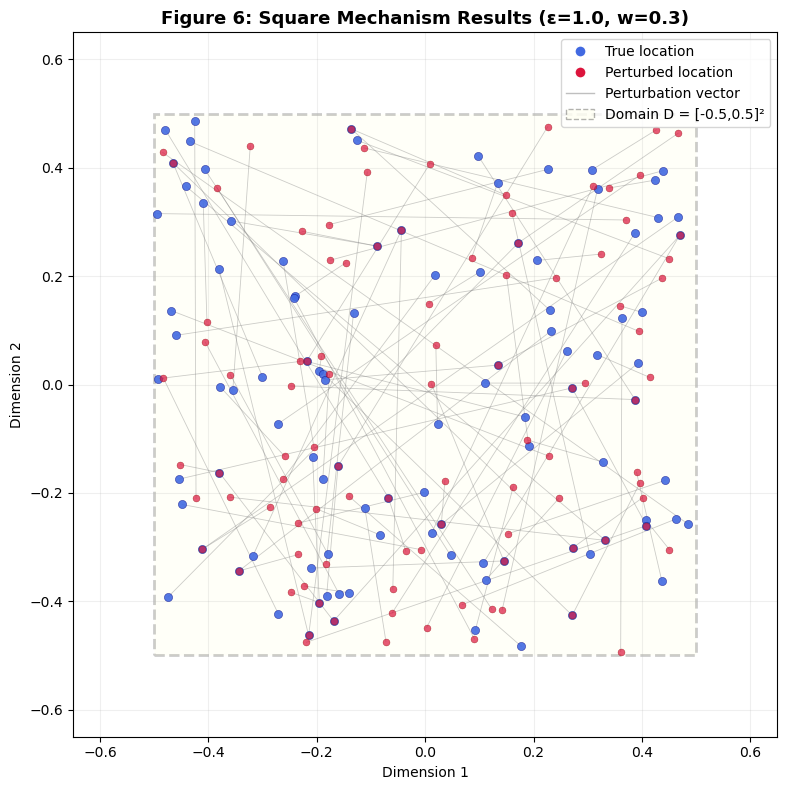


✓ All 100 perturbed points remain within the domain D.
  No domain escape — the privacy guarantee holds.


In [11]:
# Figure 6: Square Mechanism — Original vs. Perturbed
fig, ax = plt.subplots(figsize=(8, 8))

# Domain rectangle
ax.add_patch(patches.Rectangle((-0.5, -0.5), 1, 1, linewidth=2,
             edgecolor='black', facecolor='lightyellow', alpha=0.2, linestyle='--',
             label='Domain D'))

# Draw perturbation lines
for i in range(n):
    dist = np.linalg.norm(original_centered[i] - reported_square[i])
    if dist > 0.01:  # Only draw lines for visibly perturbed points
        ax.plot([original_centered[i, 0], reported_square[i, 0]],
                [original_centered[i, 1], reported_square[i, 1]],
                color='grey', linewidth=0.6, alpha=0.4)

# True locations
ax.scatter(original_centered[:, 0], original_centered[:, 1],
           c='royalblue', s=35, alpha=0.9, edgecolors='navy',
           linewidths=0.3, zorder=3)

# Perturbed locations
ax.scatter(reported_square[:, 0], reported_square[:, 1],
           c='crimson', s=25, alpha=0.7, edgecolors='darkred',
           linewidths=0.3, zorder=4)

# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='royalblue',
           markersize=8, label='True location'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='crimson',
           markersize=8, label='Perturbed location'),
    Line2D([0], [0], color='grey', linewidth=1, alpha=0.5,
           label='Perturbation vector'),
    patches.Patch(edgecolor='black', facecolor='lightyellow', alpha=0.3,
                  linestyle='--', label=f'Domain D = [-{b1},{b1}]²')
]
ax.legend(handles=legend_elements, fontsize=10, loc='upper right')

ax.set_xlim(-0.65, 0.65)
ax.set_ylim(-0.65, 0.65)
ax.set_aspect('equal')
ax.set_title(f'Figure 6: Square Mechanism Results (ε={epsilon}, w={w})',
             fontsize=13, fontweight='bold')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

print(f"\n✓ All {n} perturbed points remain within the domain D.")
print(f"  No domain escape — the privacy guarantee holds.")

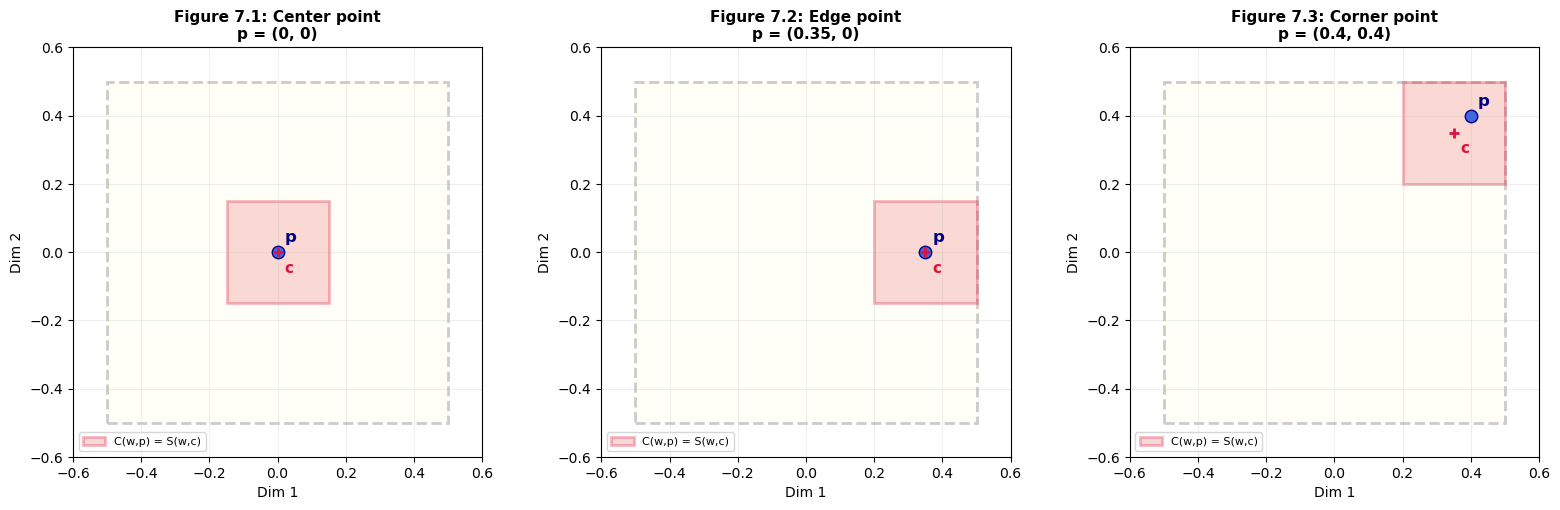

Figure 7 shows how the w-closest square adapts based on point position:
  7.1: Center — square is centered on p (C(w,p) = S(w,p))
  7.2: Edge   — center is shifted inward to keep square inside D
  7.3: Corner — center is shifted to (b1-w/2, b2-w/2) to stay inside D


In [12]:
# Figure 7: Visualizing the w-Closest Square for Selected Points

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Three example points: center, edge, corner
example_points = [
    np.array([0.0, 0.0]),      # Center of domain
    np.array([0.35, 0.0]),     # Near right edge
    np.array([0.4, 0.4]),      # Near corner
]
example_labels = ['Center point\np = (0, 0)', 'Edge point\np = (0.35, 0)', 'Corner point\np = (0.4, 0.4)']

for idx, (pt, label) in enumerate(zip(example_points, example_labels)):
    ax = axes[idx]
    
    # Domain
    ax.add_patch(patches.Rectangle((-b1, -b2), 2*b1, 2*b2, linewidth=2,
                 edgecolor='black', facecolor='lightyellow', alpha=0.2, linestyle='--'))
    
    # Compute optimal center
    c = compute_optimal_center(pt, b1, b2, w)
    
    # w-closest square C(w,p)
    ax.add_patch(patches.Rectangle((c[0]-w/2, c[1]-w/2), w, w, linewidth=2,
                 edgecolor='crimson', facecolor='lightcoral', alpha=0.3,
                 linestyle='-', label=f'C(w,p) = S(w,c)'))
    
    # True point
    ax.scatter([pt[0]], [pt[1]], c='royalblue', s=80, zorder=5,
               edgecolors='navy', linewidths=1)
    ax.annotate('p', (pt[0]+0.02, pt[1]+0.03), fontsize=12, fontweight='bold',
                color='navy')
    
    # Optimal center
    ax.scatter([c[0]], [c[1]], c='crimson', s=60, marker='+', zorder=5, linewidths=2)
    ax.annotate('c', (c[0]+0.02, c[1]-0.06), fontsize=11, fontweight='bold',
                color='crimson')
    
    ax.set_xlim(-0.6, 0.6)
    ax.set_ylim(-0.6, 0.6)
    ax.set_aspect('equal')
    ax.set_title(f'Figure 7.{idx+1}: {label}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Dim 1')
    ax.set_ylabel('Dim 2')
    ax.grid(True, alpha=0.2)
    ax.legend(fontsize=8, loc='lower left')

plt.tight_layout()
plt.show()

print("Figure 7 shows how the w-closest square adapts based on point position:")
print("  7.1: Center — square is centered on p (C(w,p) = S(w,p))")
print("  7.2: Edge   — center is shifted inward to keep square inside D")
print("  7.3: Corner — center is shifted to (b1-w/2, b2-w/2) to stay inside D")

### 15. Comparison: Gaussian Mechanism vs. Square Mechanism

Figure 8 provides a direct side-by-side comparison of both mechanisms applied to the same original dataset. This makes the advantage of the Square Mechanism visually apparent.

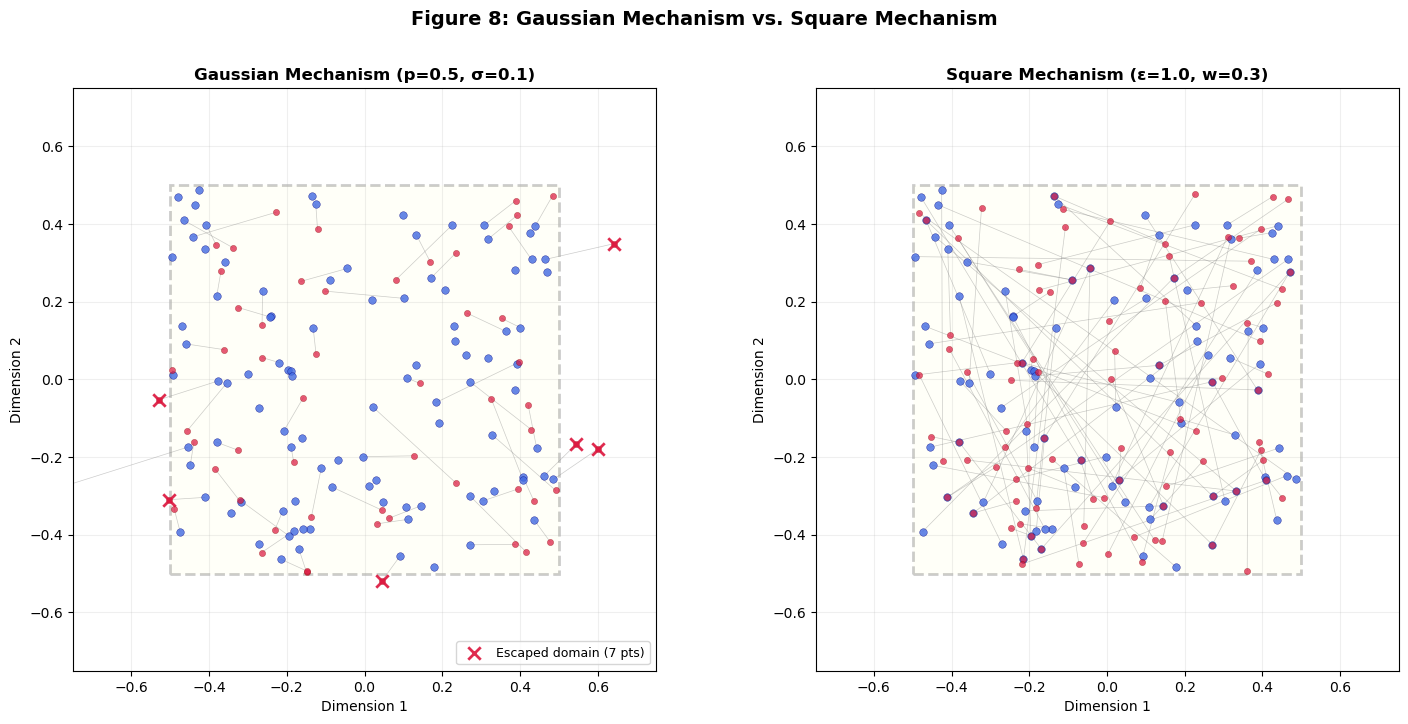


Gaussian: 7 points escaped the domain (privacy leak)
Square:   0 points escaped the domain (privacy preserved ✓)


In [13]:
# Figure 8: Side-by-Side Comparison — Gaussian vs. Square Mechanism

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# --- Left: Gaussian Mechanism ---
# Shift Gaussian results to centered domain for fair comparison
reported_gauss_centered = reported_gauss - 0.5

ax1.add_patch(patches.Rectangle((-0.5, -0.5), 1, 1, linewidth=2,
             edgecolor='black', facecolor='lightyellow', alpha=0.2, linestyle='--'))

for i in range(n):
    if noisy_mask[i]:
        ax1.plot([original_centered[i, 0], reported_gauss_centered[i, 0]],
                [original_centered[i, 1], reported_gauss_centered[i, 1]],
                color='grey', linewidth=0.5, alpha=0.4)

ax1.scatter(original_centered[:, 0], original_centered[:, 1],
           c='royalblue', s=30, alpha=0.8, edgecolors='navy', linewidths=0.3, zorder=3)
ax1.scatter(reported_gauss_centered[noisy_mask, 0], reported_gauss_centered[noisy_mask, 1],
           c='crimson', s=20, alpha=0.7, edgecolors='darkred', linewidths=0.3, zorder=4)

# Mark escaped points
escaped_mask = ((reported_gauss_centered[:, 0] < -0.5) | (reported_gauss_centered[:, 0] > 0.5) |
                (reported_gauss_centered[:, 1] < -0.5) | (reported_gauss_centered[:, 1] > 0.5))
if escaped_mask.sum() > 0:
    ax1.scatter(reported_gauss_centered[escaped_mask, 0], reported_gauss_centered[escaped_mask, 1],
               c='crimson', s=80, alpha=0.9, marker='x', linewidths=2, zorder=5,
               label=f'Escaped domain ({escaped_mask.sum()} pts)')
    ax1.legend(fontsize=9, loc='lower right')

ax1.set_xlim(-0.75, 0.75)
ax1.set_ylim(-0.75, 0.75)
ax1.set_aspect('equal')
ax1.set_title(f'Gaussian Mechanism (p={p}, σ={sigma})', fontsize=12, fontweight='bold')
ax1.set_xlabel('Dimension 1')
ax1.set_ylabel('Dimension 2')
ax1.grid(True, alpha=0.2)

# --- Right: Square Mechanism ---
ax2.add_patch(patches.Rectangle((-0.5, -0.5), 1, 1, linewidth=2,
             edgecolor='black', facecolor='lightyellow', alpha=0.2, linestyle='--'))

for i in range(n):
    dist = np.linalg.norm(original_centered[i] - reported_square[i])
    if dist > 0.01:
        ax2.plot([original_centered[i, 0], reported_square[i, 0]],
                [original_centered[i, 1], reported_square[i, 1]],
                color='grey', linewidth=0.5, alpha=0.4)

ax2.scatter(original_centered[:, 0], original_centered[:, 1],
           c='royalblue', s=30, alpha=0.8, edgecolors='navy', linewidths=0.3, zorder=3)
ax2.scatter(reported_square[:, 0], reported_square[:, 1],
           c='crimson', s=20, alpha=0.7, edgecolors='darkred', linewidths=0.3, zorder=4)

ax2.set_xlim(-0.75, 0.75)
ax2.set_ylim(-0.75, 0.75)
ax2.set_aspect('equal')
ax2.set_title(f'Square Mechanism (ε={epsilon}, w={w})', fontsize=12, fontweight='bold')
ax2.set_xlabel('Dimension 1')
ax2.set_ylabel('Dimension 2')
ax2.grid(True, alpha=0.2)

plt.suptitle('Figure 8: Gaussian Mechanism vs. Square Mechanism', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\nGaussian: {escaped_mask.sum()} points escaped the domain (privacy leak)")
print(f"Square:   0 points escaped the domain (privacy preserved ✓)")

### 16. Effect of $\varepsilon$ on the Square Mechanism

Figure 9 demonstrates how different values of $\varepsilon$ affect the perturbation. Smaller $\varepsilon$ means stronger privacy but more uniform noise (points spread across the entire domain). Larger $\varepsilon$ means weaker privacy but points stay closer to their true locations.

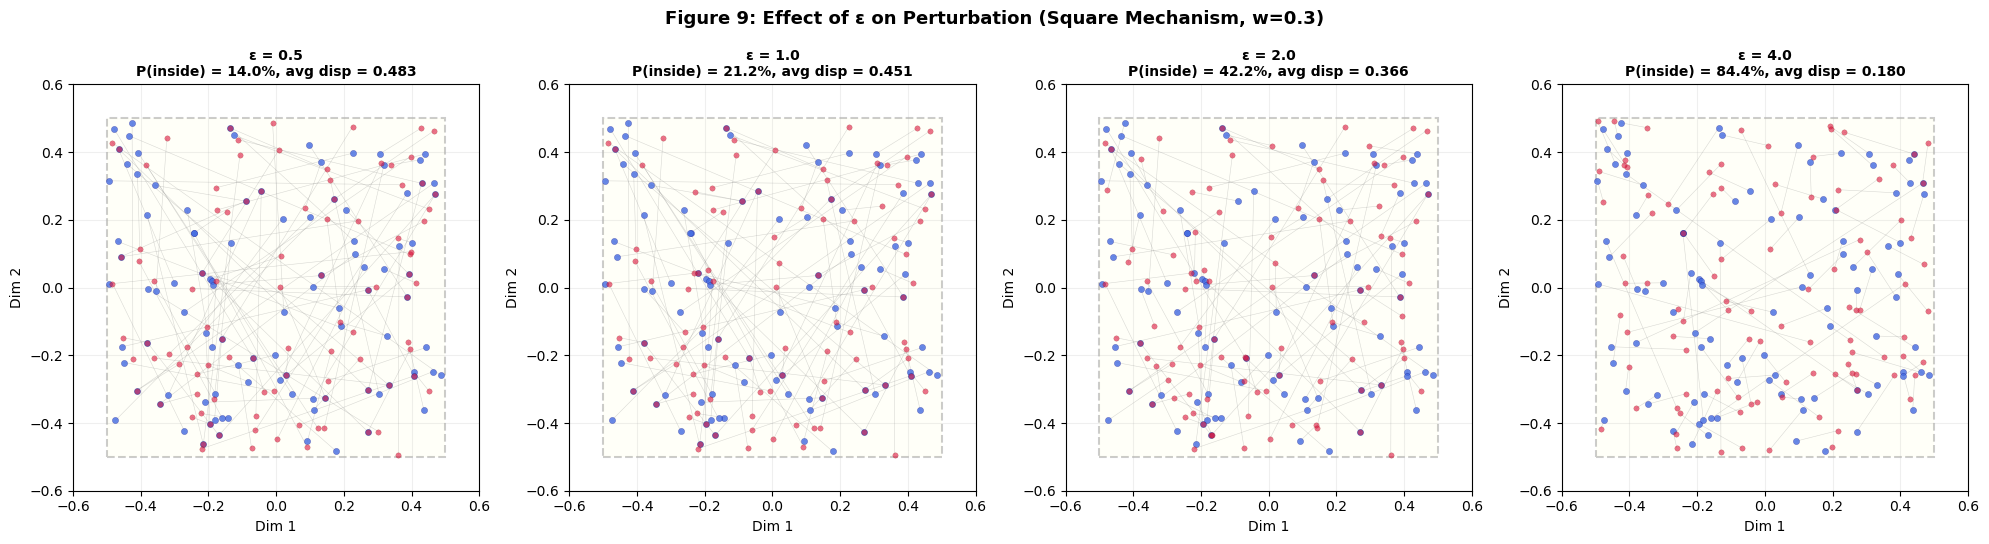

In [14]:
# Figure 9: Effect of ε on the Square Mechanism

epsilons_test = [0.5, 1.0, 2.0, 4.0]
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for idx, eps in enumerate(epsilons_test):
    ax = axes[idx]
    np.random.seed(42)
    reported_eps = apply_square_mechanism(original_centered, b1, b2, w, eps)
    
    ax.add_patch(patches.Rectangle((-0.5, -0.5), 1, 1, linewidth=1.5,
                 edgecolor='black', facecolor='lightyellow', alpha=0.2, linestyle='--'))
    
    for i in range(n):
        dist = np.linalg.norm(original_centered[i] - reported_eps[i])
        if dist > 0.01:
            ax.plot([original_centered[i, 0], reported_eps[i, 0]],
                    [original_centered[i, 1], reported_eps[i, 1]],
                    color='grey', linewidth=0.4, alpha=0.3)
    
    ax.scatter(original_centered[:, 0], original_centered[:, 1],
               c='royalblue', s=20, alpha=0.8, edgecolors='navy', linewidths=0.2, zorder=3)
    ax.scatter(reported_eps[:, 0], reported_eps[:, 1],
               c='crimson', s=15, alpha=0.6, edgecolors='darkred', linewidths=0.2, zorder=4)
    
    # Compute probability of sampling inside
    alpha = 1.0 / (w**2 * (np.exp(eps) - 1) + 4 * b1 * b2)
    p_in = alpha * np.exp(eps) * w**2
    
    # Compute average displacement
    avg_disp = np.mean(np.linalg.norm(original_centered - reported_eps, axis=1))
    
    ax.set_xlim(-0.6, 0.6)
    ax.set_ylim(-0.6, 0.6)
    ax.set_aspect('equal')
    ax.set_title(f'ε = {eps}\nP(inside) = {p_in:.1%}, avg disp = {avg_disp:.3f}',
                 fontsize=10, fontweight='bold')
    ax.set_xlabel('Dim 1')
    ax.set_ylabel('Dim 2')
    ax.grid(True, alpha=0.2)

plt.suptitle('Figure 9: Effect of ε on Perturbation (Square Mechanism, w=0.3)',
             fontsize=13, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()

### 17. Utility Analysis: Measuring Data Quality After Perturbation

A key concern in differential privacy is the **privacy-utility tradeoff**. We quantify utility by measuring the average displacement (Euclidean distance) between true and perturbed locations across different values of $\varepsilon$ and $w$.

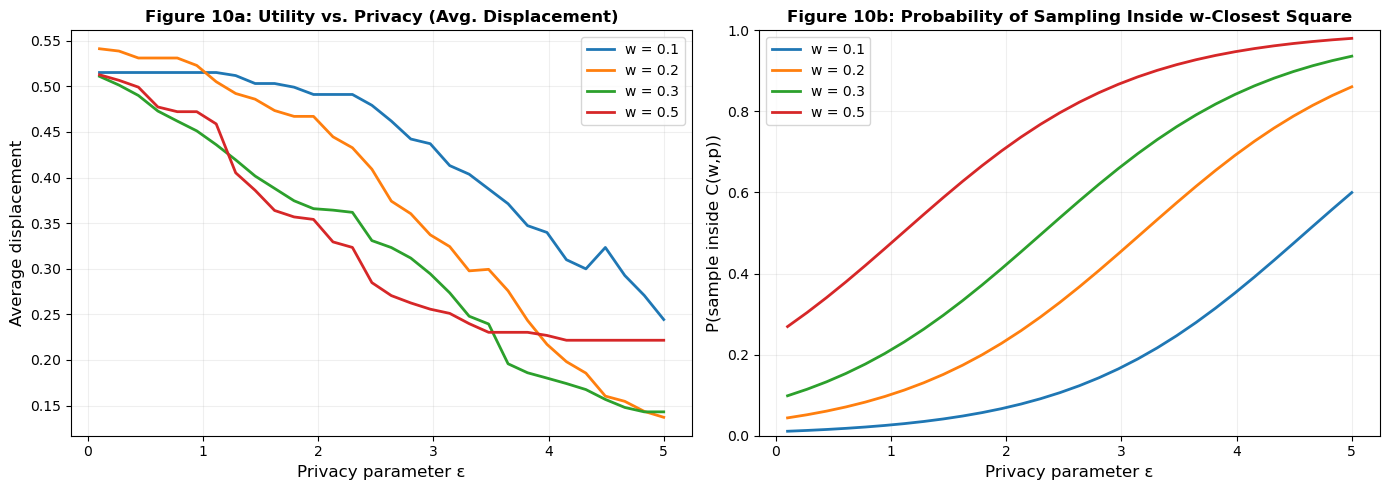

Interpretation:
  - As ε increases: displacement decreases, P(inside) increases → better utility, weaker privacy
  - As w increases: the 'hotspot' region is larger → less precise but higher P(inside)
  - The tradeoff is controlled by both ε and w jointly


In [15]:
# Code Block 9: Privacy-Utility Tradeoff Analysis

eps_range = np.linspace(0.1, 5.0, 30)
w_values = [0.1, 0.2, 0.3, 0.5]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# --- Left: Average displacement vs epsilon for different w ---
for w_test in w_values:
    avg_displacements = []
    for eps in eps_range:
        np.random.seed(42)
        rep = apply_square_mechanism(original_centered, b1, b2, w_test, eps)
        avg_d = np.mean(np.linalg.norm(original_centered - rep, axis=1))
        avg_displacements.append(avg_d)
    ax1.plot(eps_range, avg_displacements, linewidth=2, label=f'w = {w_test}')

ax1.set_xlabel('Privacy parameter ε', fontsize=12)
ax1.set_ylabel('Average displacement', fontsize=12)
ax1.set_title('Figure 10a: Utility vs. Privacy (Avg. Displacement)', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.2)

# --- Right: P(inside) vs epsilon for different w ---
for w_test in w_values:
    p_inside_vals = []
    for eps in eps_range:
        alpha = 1.0 / (w_test**2 * (np.exp(eps) - 1) + 4 * b1 * b2)
        p_in = alpha * np.exp(eps) * w_test**2
        p_inside_vals.append(p_in)
    ax2.plot(eps_range, p_inside_vals, linewidth=2, label=f'w = {w_test}')

ax2.set_xlabel('Privacy parameter ε', fontsize=12)
ax2.set_ylabel('P(sample inside C(w,p))', fontsize=12)
ax2.set_title('Figure 10b: Probability of Sampling Inside w-Closest Square', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.2)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

print("Interpretation:")
print("  - As ε increases: displacement decreases, P(inside) increases → better utility, weaker privacy")
print("  - As w increases: the 'hotspot' region is larger → less precise but higher P(inside)")
print("  - The tradeoff is controlled by both ε and w jointly")

---

## 18. Summary and Key Findings

This notebook progressed through four stages of understanding differential privacy for location data:

**Part I** demonstrated the intuitive idea of adding noise for privacy using a Gaussian mechanism. While visually informative, we identified three critical limitations: (1) perturbed points can escape the bounded domain, leaking privacy; (2) the mechanism does not satisfy formal $\varepsilon$-DP; and (3) there is no principled way to calibrate the privacy-utility tradeoff.

**Part II** introduced the formal definition of $\varepsilon$-differential privacy, establishing the mathematical foundation: for any two neighboring inputs, the probability ratio of any output must be bounded by $e^{\varepsilon}$.

**Part III** distinguished between Central DP (trusted curator adds noise to aggregates) and Local DP (each individual perturbs their own data). For location privacy, LDP is the appropriate model since it requires no trusted server.

**Part IV** implemented the **Square Mechanism**, a provably $\varepsilon$-differentially private mechanism for bounded 2D location domains under LDP. Key advantages over the Gaussian approach:

| Property | Gaussian Mechanism | Square Mechanism |
|---|---|---|
| Privacy guarantee | Informal / approximate | Provably $\varepsilon$-DP |
| Domain containment | Points can escape | All points stay in $\mathcal{D}$ |
| Privacy model | N/A | Local DP (no trusted server) |
| Parameters | $p$, $\sigma$ (ad hoc) | $\varepsilon$, $w$ (principled) |
| Utility control | Unprincipled | Tunable via $\varepsilon$ and $w$ |

---

### Next Steps

1. **Formal privacy proof:** Verify that the implemented square mechanism satisfies $\varepsilon$-DP by checking the probability ratio bound empirically.
2. **Optimal $w$ selection:** Investigate how to choose $w$ to minimize expected error for a given $\varepsilon$.
3. **Real-world data:** Apply the mechanism to real location datasets (e.g., GPS traces, check-in data).
4. **Extension to higher dimensions:** Generalize the square mechanism to hypercube mechanisms in $d > 2$ dimensions.
5. **Comparison with other mechanisms:** Benchmark against the Planar Laplace mechanism and other geo-indistinguishability approaches.